In [8]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [9]:
data = pd.read_csv('data/umist_cropped_with_cluster_id_training.csv')
val_data = pd.read_csv(r'data\validation_data\umist_cropped_with_cluster_id_val.csv')
test_data = pd.read_csv('data/test_data/umist_test.csv')

In [10]:
X_train = data.drop(['cluster_id'],axis = 1)
y_train = data['cluster_id']

X_val = val_data.drop(['cluster_id'],axis = 1)
y_val = val_data['cluster_id']

X_test = test_data

In [11]:
y_train -= 1
y_val -= 1

In [12]:
# Extract pixel values and reshape
X_train = X_train.values.reshape(-1, 112, 92, 1)

X_val = X_val.values.reshape(-1, 112, 92, 1)

X_test = X_test.values.reshape(-1, 112, 92, 1)

In [13]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [14]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [15]:
print(f"Image tensor shape: {X_train.shape}")  # Should print (num_samples, 112, 92, 1)

Image tensor shape: (600, 112, 92, 1)


In [16]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 20
NUMBER_OF_TRAINING_IMAGES = 600

In [17]:
model = models.Sequential()

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 92, 512)   │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 46, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 44, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614,874 (17.60 MB)

 Trainable params: 4,614,874 (17.60 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
)

model_checkpoint = ModelCheckpoint(
    filepath='models/classifier/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)


In [20]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [21]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.0684 - loss: 14.3170
Epoch 1: val_accuracy improved from -inf to 0.06195, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 966ms/step - accuracy: 0.0694 - loss: 14.2520 - val_accuracy: 0.0619 - val_loss: 10.4148
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.1676 - loss: 9.3689
Epoch 2: val_accuracy improved from 0.06195 to 0.24779, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 891ms/step - accuracy: 0.1694 - loss: 9.3281 - val_accuracy: 0.2478 - val_loss: 6.8306
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.2727 - loss: 6.2693
Epoch 3: val_accuracy improved from 0.24779 to 0.46903, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - accuracy: 0.2755 - loss: 6.2428 - val_accuracy: 0.4690 - val_loss: 4.4263
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.5

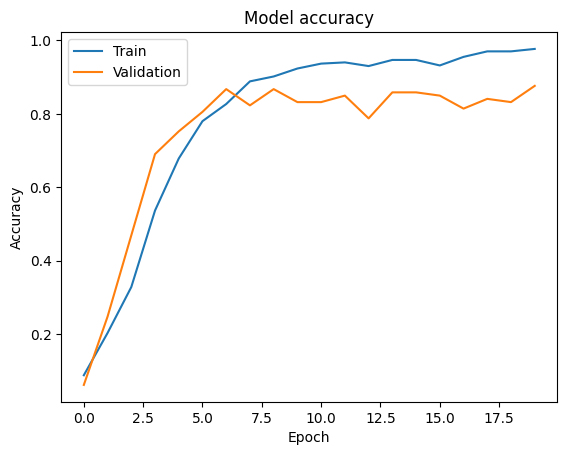

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

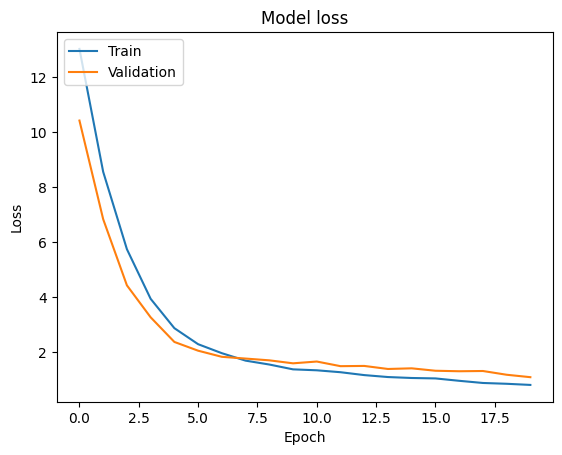

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
best_model = models.load_model('models/classifier/best_model.keras')

In [25]:
y_test_pred = best_model.predict(tf.expand_dims(X_test[2], axis=0))

print(f"Predicted class: {np.argmax(y_test_pred) + 1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted class: 1


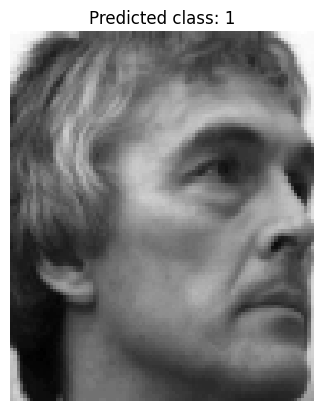

In [27]:
plt.imshow(X_test[2].numpy().reshape(112, 92), cmap='gray')
plt.title(f"Predicted class: {np.argmax(y_test_pred) + 1}")
plt.axis('off')
plt.show()